In [30]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# scipy is an extension for numpy, used extensively in scientific computing
from scipy.sparse import linalg
from scipy.sparse import lil_matrix, csc_matrix

# here we import the functions translated from matlab
# to do so, we need to change the relative path
import sys
sys.path.append('../FEM')

import Mesher
import Matrix
import PoroElasticProperties as prop

### Fluid injection in a porous media

We will model the injection of a fluid with a constant rate $Q$ in a wellbore of radius $r_w$ into a porous reservoir of radius $R$.

To do so, we will:

- Create the mesh using ``pygmsh``
  - We will need to specify where we locate *holes* in our mesh
- Impose the boundary conditions
  - There will be a constand flux at the wellbore and no flow at the reservoir boundary
- Compute the temporal evolution of the pressure in the domain
  - The $\theta$ method will be needed here
- Compare the numerical solution to analytical solutions
  - Two different analytical solutions will be computed, making use of different assumptions 

In [29]:
# We will start by defining the mesh

import pygmsh

# different radius for the wellbore r and the domain R
r = 1
R = 30 * r

with pygmsh.geo.Geometry() as geom:

    # we need the outer and inner circles to be defined as curved loops rather than surfaces
    # the make_surface=False keyword is needed
    outer = geom.add_circle([0, 0], R, mesh_size=5, make_surface=False)
    inner = geom.add_circle([0, 0], r, mesh_size=0.5, make_surface=False)

    # we can pass a list of holes to the add_plane_surface function
    surface = geom.add_plane_surface(outer.curve_loop, holes=[inner])
    out = geom.generate_mesh()

mesh = Mesher.Mesh(out)

mesh.plot()
#plt.scatter(*mesh.nodes.T, c='tab:blue', s=10, zorder=10, ec='k')
print(f'Mesh has {mesh.nn} nodes')


Mesh has 476 nodes


### Boundary conditions

We first start by selecting the nodes located at the wellbore radius $r_w$ and the domain radius $R$. We will use boolean logic just like usual! However, we need to define a small error threshold because of numerical precision.

(-1.5, 1.5)

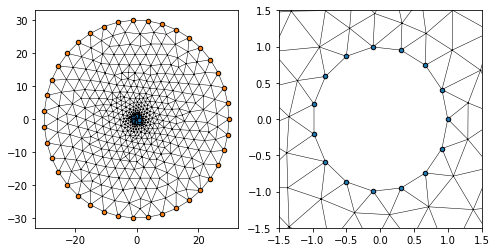

In [4]:

# we need to select the nodes for the two different boundaries to set the proper boundary conditions
borehole = np.argwhere(np.abs(np.linalg.norm(mesh.nodes, axis=1) - r) < 1e-3)
outer = np.argwhere(np.abs(np.linalg.norm(mesh.nodes, axis=1) - R) < 1e-3)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
for i in range(2):
    mesh.plot(ax=axs[i])

    axs[i].scatter(*mesh.nodes[borehole].T, s=20, zorder=10, ec='k')
    axs[i].scatter(*mesh.nodes[outer].T, s=20, zorder=10, ec='k')

axs[1].set_xlim(-1.5 * r, 1.5 * r)
axs[1].set_ylim(-1.5 * r, 1.5 * r)


Now that we've selected the nodes at the proper boundaries, we can compute the force vector! We need to compute the flux $q_e$ at every element. Knowing that the total flux is $Q$, what should it be element wise?

In [5]:
# now we want to compute the force vector
Q = 1
circumference = 2*np.pi*r
q = Q/circumference

arc_length = circumference/len(borehole)
f = np.zeros(mesh.nn)
f[borehole] = q * arc_length * r

In [6]:
# we now define the conductivity matrices
C = Matrix.assemble_conductivity_matrix(mesh, 1)
M = Matrix.assemble_mass_matrix(mesh, 1)

c:\ProgramData\Anaconda3\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


### Temporal evolution of the pressure

We can use the $\theta$ method to solve the time-stepping problem. Check out the course notes and the last exercise!

iteration 1999 out of 1999

(<Figure size 432x288 with 2 Axes>,
 <AxesSubplot:>,
 <matplotlib.colorbar.Colorbar at 0x2210a099c70>)

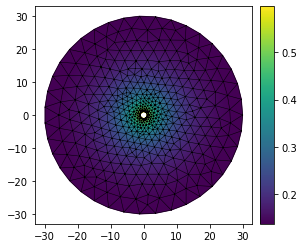

In [34]:
# we can solve the system of equations at every time step
theta = 0.8
eye = np.eye(mesh.nn)

nt = 2000
tmax = 500
t = np.linspace(0, tmax, nt)
dt = t[1] - t[0]
pressure = np.zeros((nt, mesh.nn))

D =  M + theta * dt * C

for i in range(len(t) - 1):
    print(f'\riteration {i + 1} out of {len(t) - 1}', end='')
    right = dt * (f - C*pressure[i])
    dp = linalg.spsolve(D, right)
    pressure[i + 1] = pressure[i] + dp

mesh.plot(pressure[-1])

### Analysing the results
Now that we have results in three dimensions (two spatial dimensions + time), we'd like to look at the temporal evolution of the pressure at a few points in the domain. From the radial symmetry of the problem, we can look at the pressure for a few points along a line.

[ 1.        10.0407555 30.       ]


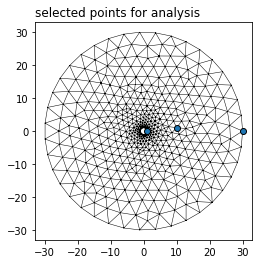

In [37]:
# we want to look at the temporal evoluotion of the pressure for a few given points
radiuses = [r, R/3, R]

# since the mesh is not exactly defined at those intervals, we want to take only the closest points
indices = np.zeros(len(radiuses), dtype=int)
for i, radi in enumerate(radiuses):
    distance = np.abs(np.linalg.norm(mesh.nodes, axis=1) - radi)
    indices[i] = distance.argmin()

# we can check what that looks like
points = mesh.nodes[indices]
mesh.plot()
plt.scatter(*points.T, zorder=10, ec='k')
plt.title('selected points for analysis', loc='left')
print(np.linalg.norm(points, axis=1))

### Comparison with analytical solutions

We can try to analytical solutions:

- Line source in an infinite reservoir
This one approximates the wellbore as a line source and that the domain is infinite, also known as the *Theis solution* in hydrogeology. When the fluid front reaches the domain boundary, the solution is no longer valid due to the zero flux condition. We can consider the solution an *early-time* approximation. The solution is

$$ p(r, t) = \frac{Q}{4\pi k}\mathrm{Ei}\left(\frac{r^2}{4ct}\right),$$

where $Q$ is the flux, $k$ is the permeability coefficient, $c=k/S$ where $S$ is the storage coefficient and $\mathrm{Ei}(x)$ is the exponential integral function.

- Cylindrical source in a finite reservoir

This solution is more realistic and considers a finite size for both the wellbore and the reservoir. This solution can be deemed as a *pseudo steady-state*$* approximation. This one is a bit of mess and goes like this

$$ p(r, t) = \frac{Q}{4\pi k}\left[\frac{2}{R^2_D - 1}\left(\frac{r^2_D}{4} + t_D\right) - \frac{R^2_D \ln(r_D)}{R^2_D - 1} - \frac{3R^4_D - 4R^4_D \ln(r_D)-2R^2_D - 1}{4(R_D^2 - 1)^2} \right],$$

where $R_D=R/r_w$, $r_D = r/r_w$ and $t_D = t/(cr^2_w)$.

We have coded those solutions for you in the next cell.

In [38]:
# we can try some analytical solutions
from scipy.special import exp1

def line_source(radi, t, Q, k=1, S=1):
    c = k/S
    r2 = radi * radi
    return Q/(4*np.pi*k) * exp1(r2 / (4 * c * t))
    
def cylindrical_source(radi, wellbore_radi, reservoir_radi, t, Q, k=1, S=1):
    Rd = reservoir_radi/wellbore_radi
    rd = radi/wellbore_radi
    c = k/S
    td = t / (c * wellbore_radi * wellbore_radi)

    A = 2 / ((Rd ** 2) - 1) * ((rd ** 2) / 4 + td)
    B = (Rd ** 2) * np.log(rd) / ((Rd ** 2) - 1)
    C_up = (3 * Rd ** 4) - 4 * np.log(Rd) * (Rd ** 4) - 2 * (Rd ** 2) - 1
    C_down = 4 * ((Rd ** 2) - 1)**2

    return Q/(2 * np.pi * k) * (A - B - C_up / C_down)


<ipython-input-38-c76eae89427f>:7: RuntimeWarning: divide by zero encountered in true_divide
  return Q/(4*np.pi*k) * exp1(r2 / (4 * c * t))
<ipython-input-38-c76eae89427f>:7: RuntimeWarning: divide by zero encountered in true_divide
  return Q/(4*np.pi*k) * exp1(r2 / (4 * c * t))
<ipython-input-38-c76eae89427f>:7: RuntimeWarning: divide by zero encountered in true_divide
  return Q/(4*np.pi*k) * exp1(r2 / (4 * c * t))


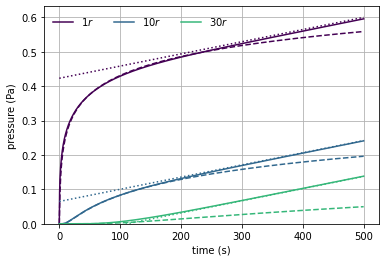

In [48]:
# making of a pretty plot to compare the solutions
labels = [f'{radi/r:.0f}$r$' for radi in radiuses]
cmap = plt.get_cmap('viridis')
colors = [cmap(i/len(labels)) for i in range(len(labels))]

# our pressure array has shape (n_timesteps, n_nodes)
for i, p in enumerate(pressure[:, indices].T):
    plt.plot(t, p, label=labels[i], color=colors[i])
    plt.plot(t, line_source(radiuses[i], t, Q), c=colors[i], ls='dashed')
    plt.plot(t, cylindrical_source(radiuses[i], r, R, t, Q), c=colors[i], ls='dotted')

plt.legend(ncol=3, loc='upper left', frameon=False)
plt.xlabel('time (s)')
plt.ylabel('pressure (Pa)')
plt.ylim(0, None)
plt.grid()


In [28]:
%matplotlib qt
# as always, we can animate it

from matplotlib.animation import FuncAnimation

fig = plt.figure()
ax = fig.add_subplot()
im = ax.tripcolor(*mesh.nodes.T, mesh.connectivity[:, :3], pressure[0], shading='gouraud', vmin=pressure.min(), vmax=pressure.max())
plt.colorbar(im)
mesh.plot(ax=ax, c='gray')
ax.set_aspect(1)

time = ax.set_title('t=0')

def update(i):
    time.set_text(f't={t[i]:.2f}')
    im.set_array(pressure[i])
    return im, time

ani = FuncAnimation(fig, update, frames=np.arange(0, len(t), 10), interval=0.1)
